<a href="https://colab.research.google.com/github/adharangaonkar/Image-Processing-and-Computer-Vision/blob/main/Digit_Recognition/Image_Recognition_MNIST_Dataset_using_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torchvision

In [2]:
# !pip3 install pillow==7.1.0

In [3]:
# !pip3 uninstall pillow

In [4]:
import torch

In [5]:
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np 

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
transform= transforms.Compose([transforms.Resize([28, 28])
                               , transforms.ToTensor() , # transfor the numpy array to a float tensor
                               transforms.Normalize((0.5,), (0.5,) )])
                               # normalizes the tensor image with mean and standard deviation in the range -1, 1 from 0,1 
                               # nomralization helps reduce Skewness and distortions within out data ensuring a more effective learning process
training_dataset = datasets.MNIST(root= './data',train=True, download=True, transform= transform )
validation_dataset = datasets.MNIST(root= './data', 
                                  train=False, download=True, transform= transform )


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Training Loader

In [8]:
# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size= 100, shuffle = 
#                                             True)

### Plotting the Images

To plot the images, we need to convert the tensors back to Numpy arrays

In [9]:
def im_convert(tensor):   # to convert the tensor into numpy arrays
  image = tensor.cpu().clone().detach().numpy()
  # tensor.detach() creates a tensor that shares storage with tensor that does not require grad 
  # It detaches the output from the computational graph
  # So no gradient will be backpropagated along this variable
  image = image.transpose(1,2,0)
  # Image is in the form of (1, 28 ,28) that is (channels, width, height)
  # We need to swap axes to convert the arrays into (28,28,1) 
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize
  image = image.clip(0,1) # clip all the values outside(0,1)
  return image

In [10]:
# dataiter = iter(training_loader)
# images, label = dataiter.next()
# fig = plt.figure(figsize=(25,6))

# for idx in range(20):
#   ax = fig.add_subplot(2, 10, idx+1)
#   plt.imshow(im_convert(images[idx]))
#   ax.set_title(label[idx].item())

## Training Loader

In [11]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size= 100, shuffle = 
                                            True)

In [12]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size= 100, shuffle = 
                                            False)

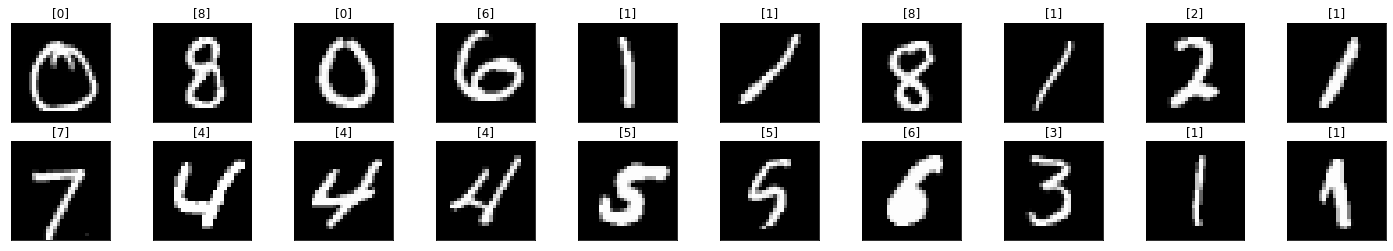

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

### Building the Model

In [14]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__() # for provision of various methods and attributes
    """
    Conv2d parameters:
    number of input channels : 1
    number of filters/ output channels : 20
    kernel / filter size : 5
    strides : 1
    """
    self.conv1 = nn.Conv2d(1, 20, 5, 1)   
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500) # (number of input channels, number of output channels)
    """
    Dropout Layers are often added between two layers having highest number of nodes
    In case of this model it is the two linear fully connected layers
    """
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10) # (number of input channels, number of output channels)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    """
    max_pool_2d parameters:
    (feedforward input, kernel_width, kernel_height)
    """ 
    x = F.max_pool2d(x, 2, 2) # cutting the size of the image in half
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2) # cutting the size of the image in half
    x = x.view(-1, 4*4*50) # reshape the shape into desired output. Similar to .flatten()
    # x.view() = x.view( number_of_columns, number_of rows) 
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    
    return x
 # no need to include the padding as the images already have a large black boundaries   

## LeNet Model Architecture

In [15]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

## Loss Function

In [16]:
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss is a combination of log_softmax() and NLLloss()
# Used with classification models with n-classes
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
# ADAM optimizer, most efficient optimizer

In [17]:
training_loader

## Training the Model

In [18]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # store the tensors in the device(GPU)
    labels = labels.to(device) # store the tensors in the device(GPU)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) # store the tensors in the device(GPU)
        val_labels = val_labels.to(device) # store the tensors in the device(GPU)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1
training loss: 0.6091, acc 83.8383 
validation loss: 0.1981, validation acc 94.2500 
epoch : 2
training loss: 0.1567, acc 95.4500 
validation loss: 0.1092, validation acc 96.7800 
epoch : 3
training loss: 0.1023, acc 96.9650 
validation loss: 0.0767, validation acc 97.6200 
epoch : 4
training loss: 0.0790, acc 97.6867 
validation loss: 0.0656, validation acc 98.0100 
epoch : 5
training loss: 0.0646, acc 98.0317 
validation loss: 0.0549, validation acc 98.2900 
epoch : 6
training loss: 0.0557, acc 98.3150 
validation loss: 0.0483, validation acc 98.4200 
epoch : 7
training loss: 0.0502, acc 98.4883 
validation loss: 0.0436, validation acc 98.7100 
epoch : 8
training loss: 0.0446, acc 98.6917 
validation loss: 0.0406, validation acc 98.7200 
epoch : 9
training loss: 0.0396, acc 98.8217 
validation loss: 0.0377, validation acc 98.8400 
epoch : 10
training loss: 0.0364, acc 98.9150 
validation loss: 0.0342, validation acc 98.9600 
epoch : 11
training loss: 0.0342, acc 98.9583 
va

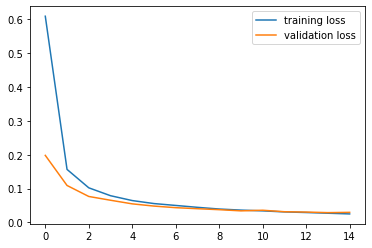

In [19]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

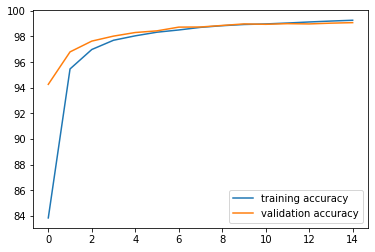

In [20]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [21]:
!pip3 uninstall pillow

Uninstalling Pillow-8.2.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-8.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libXau-312dbc56.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libXdmcp-e15573e7.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-6ad068c6.so.6.17.4
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libharfbuzz-ba5e3cba.so.0.20800.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-ba7bf5af.so.9.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-a76503ec.so.2.0.12
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-99449165.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-f0612b30.so.2.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-bedcb7ea.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-d147fec3.so.5.6.0
    /usr/

In [22]:
!pip3 install pillow

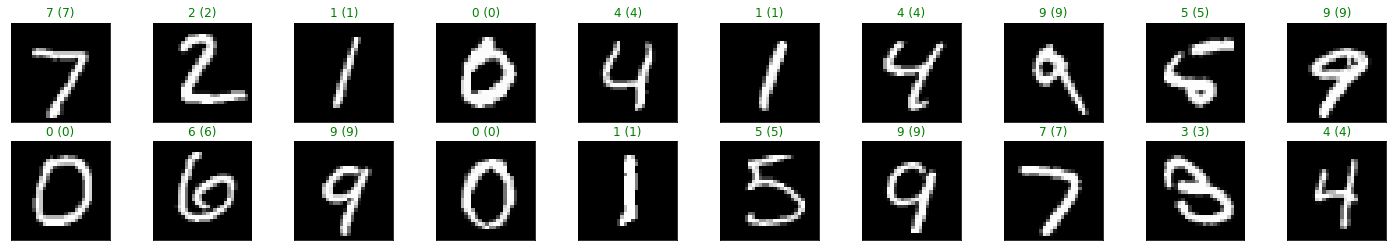

In [23]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))


In [24]:
from google.colab import files
from io import BytesIO
from PIL import Image

# uploaded = files.upload()
# im = Image.open(BytesIO(uploaded['5.jpg']))

In [25]:
import PIL.ImageOps


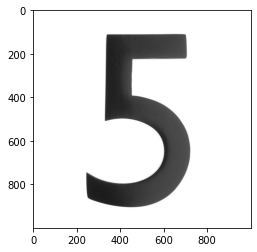

In [26]:

import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

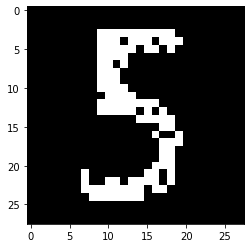

In [27]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [28]:

images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5
